In [1]:
import utils
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from tigramite import plotting, data_processing, pcmci
from tigramite.models import LinearMediation
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.independence_tests import parcorr, robust_parcorr, cmiknn, gpdc

In [6]:
# spliced greenland temperature from GIPS2, NGRIP and NEEM
data_gis = pd.read_excel("../data/Davtian/Davtian-and-Bard_2023_Greenland_GISP2_NGRIP_NEEM_Tair_129-0kaBP.xlsx")
data_gis.columns = ["site", "age", "T"]
data_gis = data_gis[data_gis.site == "NGRIP"][["age", "T"]].set_index("age")

# RI-OH based SST estimate for the Iberian margin (AMOC strength proxy)
data_amoc = pd.read_excel("../data/Davtian/Davtian-and-Bard_2023_IberianMargin_MD95-2042_Biomarkers_160-0kaBP.xlsx", usecols=[2, 8], index_col=0)

# combined antarctic temperature stack from WDC, EDC and EDML
data_ats  = pd.read_excel("../data/Davtian/Davtian-and-Bard_2023_AntarcticStacks_WD_EDC_EDML_d18Oice_Tair_140-0kaBP.xlsx", usecols=[0, 3], index_col=0)

for datum in [data_gis, data_amoc, data_ats]:
    print(datum.index.min(), datum.index.max(), datum.index.size, datum.index.diff()[1])

data = pd.concat([data_gis, data_amoc, data_ats], axis=1)

9.977028302036445 119.96055486217594 5651 0.022700017907769876
0.006 162.08180928567117 638 0.19
0.04 139.83 13980 0.010000000000000002


In [7]:
def process(age=np.linspace(15, 110, 1000), detrend='linear', standardize=True):
    
    def preprocess_datum(datum):

        # this interpolation only fills the nan values
        datum = datum.interpolate('index')
        y  = datum.iloc[:,0]

        # this interpolation downscales the data
        y = sp.interpolate.Akima1DInterpolator(datum.index, y)(age)
        #y = sp.interpolate.interp1d(datum.index, y, bounds_error=False, fill_value="extrapolate")(age)

        # detrend using linear slope
        if detrend: 
            y = sp.signal.detrend(y, type=detrend)
    
        # standardize
        if standardize: 
            y = (y - np.mean(y))/np.std(y)
    
        return pd.Series(y, index=age)
    
    data_dats = -data_ats.rolling(140, center=True).mean().diff().dropna()
    #data_dats = -data_ats.apply(lambda x: sp.signal.savgol_filter(x, 250, 2)).diff().dropna() # use savgol filter for estimating the ATS derivative
    data_processed = list(map(preprocess_datum, [data_gis, data_amoc, data_ats, data_dats]))
    data_processed = pd.concat(data_processed, axis=1).dropna().sort_index(ascending=False)
    data_processed.columns = ["GIS", "AMOC", "ATS", "dATS"]
    return data_processed

data_processed = process(detrend=False, standardize=False)

# Heinrich event mask
mask = np.where( data_processed.GIS.rolling(5, center=True).mean() <= -42.5 , "DOS", "DOI")
#mask = np.where(data_processed.AMOC.rolling(8, center=True).mean() <  11.4, "H",   mask)

# Heinrich events taken from the plot in the figure
h = np.array(((14.9, 17.7), (23.5, 26.1), (29.3, 30.5), (38.4, 40.3), (46.8, 49), (60.1, 64.1), (72, 73.6), (75.5, 78), (84.3, 89.5), (104.1, 106.5), (108.6, 110.7)))
for hi in h:
    i = np.abs(data_processed.index - hi[0]).argmin()
    j = np.abs(data_processed.index - hi[1]).argmin()
    mask[j:i] = "H"

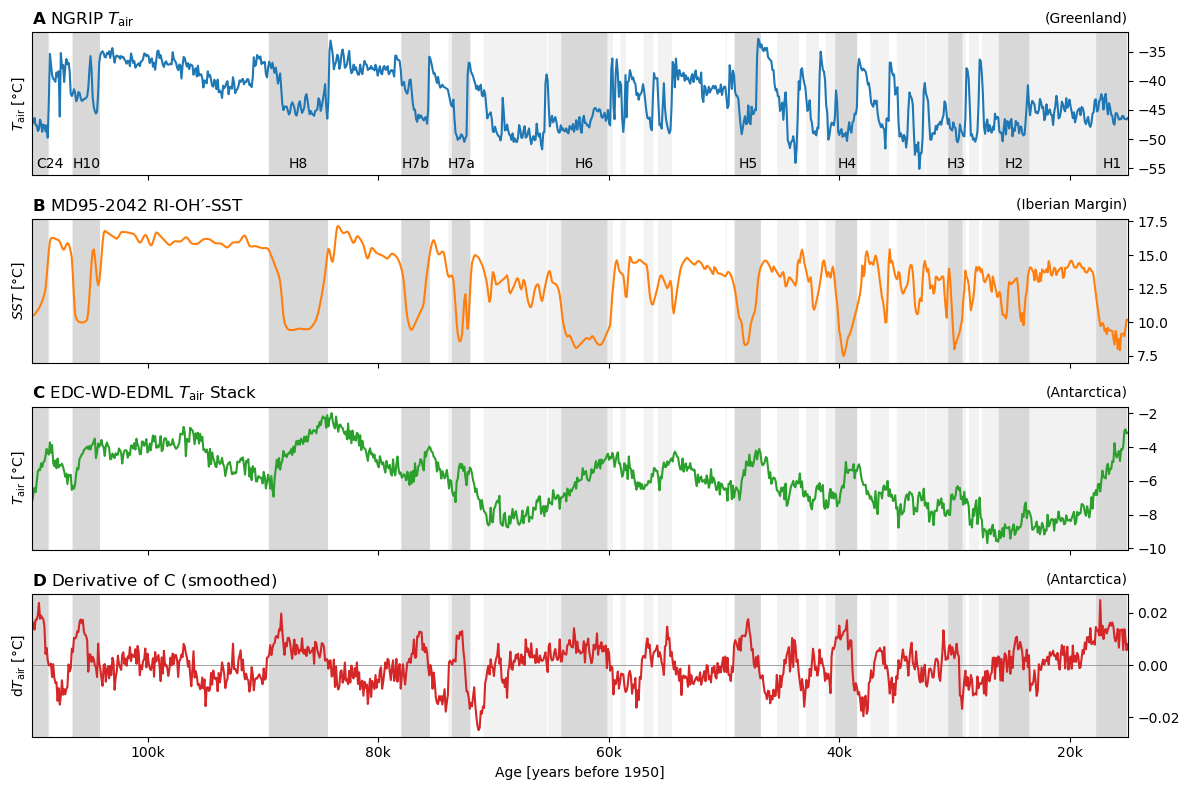

In [177]:
im = np.ones((1, 1000, 3))
im[:,mask == "H"]   = (0.85, 0.85, 0.85)
im[:,mask == "DOI"] = (1.0, 1.0, 1.0)
im[:,mask == "DOS"] = (0.95, 0.95, 0.95)

fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[3].axhline(0, color="gray", lw=0.5)

for i, (column, ax) in enumerate(zip(data_processed, axs)):
    ax.plot(data_processed[column], c=f"C{i}", label=column)
    ax.imshow(im, extent=[data_processed.index.max(), data_processed.index.min(), *ax.get_ylim()], aspect="auto")
    ax.yaxis.tick_right()

axs[0].set_title(r"$\bf{A}$ NGRIP $T_\text{air}$", ha="left", x=0)
axs[0].text(1, 1.05, "(Greenland)", ha="right", va="bottom", transform=axs[0].transAxes)
axs[0].set_ylabel(r"$T_\text{air}$ [°C]")

# labels for Heinrich events
for i, hmean in enumerate(h.mean(axis=1)):
    axs[0].text(hmean, -55, ["H1", "H2", "H3", "H4", "H5", "H6", "H7a", "H7b", "H8", "H10", "C24"][i], ha="center" if i != 10 else "left")

axs[1].set_title(r"$\bf{B}$ MD95-2042 RI-OH′-SST", ha="left", x=0)
axs[1].text(1, 1.05, "(Iberian Margin)", ha="right", va="bottom", transform=axs[1].transAxes)
axs[1].set_ylabel(r"$SST$ [°C]")

axs[2].set_title(r"$\bf{C}$ EDC-WD-EDML $T_\text{air}$ Stack", ha="left", x=0)
axs[2].text(1, 1.05, "(Antarctica)", ha="right", va="bottom", transform=axs[2].transAxes)
axs[2].set_ylabel(r"$T_\text{air}$ [°C]")
#axs[2].plot(data_processed.ATS.rolling(20, center=True).mean(), c="#9fd392")

axs[3].set_title(r"$\bf{D}$ Derivative of C (smoothed)", ha="left", x=0)
axs[3].text(1, 1.05, "(Antarctica)", ha="right", va="bottom", transform=axs[3].transAxes)
axs[3].set_ylabel(r"d$T_\text{air}$ [°C]")
axs[3].xaxis.set_major_formatter(lambda x, pos: f"{x:.0f}k")
axs[3].set_xlabel("Age [years before 1950]")

plt.tight_layout()
plt.savefig("../plots/davtian_proxies.png", dpi=200, bbox_inches="tight")

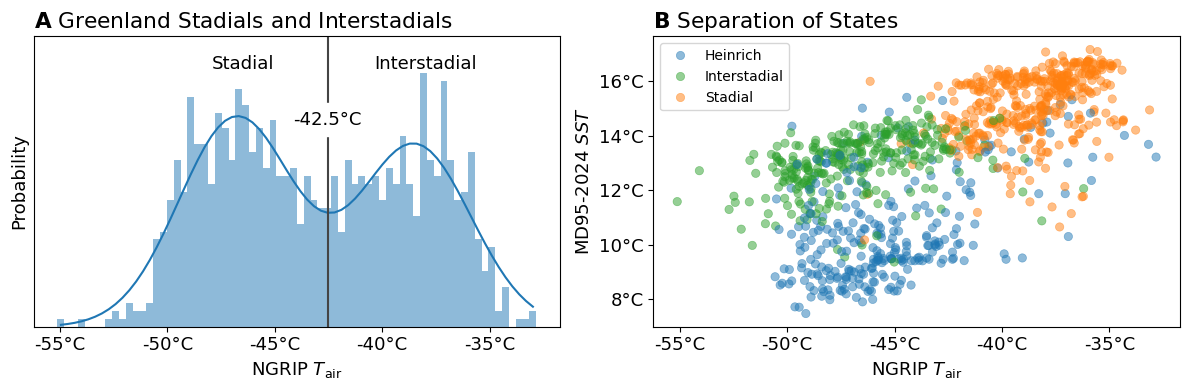

In [15]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.set_title(r"$\bf{A}$ Greenland Stadials and Interstadials", x=0, ha="left")

# histogram of NGRIP data
density, bin_edges = np.histogram(data_processed.GIS, bins=70, density=True)
bin_edges = (bin_edges[1:] + bin_edges[:-1])/2
ax.bar(bin_edges, density, width=bin_edges[1] - bin_edges[0], alpha=0.5)

# fit bimodal curve
bimodal = lambda x, mu1, mu2, s1, s2, a1, a2: a1*sp.stats.norm.pdf(x, mu1, s1) + a2*sp.stats.norm.pdf(x, mu2, s2)
params, cov = sp.optimize.curve_fit(bimodal, bin_edges, density, (-47, -38, 2, 2, 0.5, 0.5))
curve = np.array([bimodal(b, *params) for b in bin_edges])
ax.plot(bin_edges, curve)

# find minimum
T = bin_edges[sp.signal.argrelmin(curve)[0]][0]
ax.axvline(T, 0, color="#444444")
ax.text(T, 0.08, str(np.round(T, 1)) + "°C", ha="center", bbox=dict(facecolor="white", edgecolor="white"))
ax.text(-46.5, 0.102, "Stadial", ha="center")
ax.text(-38, 0.102, "Interstadial", ha="center")

ax.xaxis.set_major_formatter("{x:.0f}°C")
ax.set_xlabel(r"NGRIP $T_\text{air}$")
ax.set_ylim([0, 0.115])
ax.set_ylabel("Probability")
ax.set_yticks([])

ax = axs[1]
ax.set_title(r"$\bf{B}$ Separation of States", x=0, ha="left")

sns.scatterplot(x=data_processed.GIS, y=data_processed.AMOC, hue=mask, edgecolor=None, palette=["C0", "C2", "C1"], alpha=0.5)
[text.set_text(event) for text, event in zip(ax.get_legend().texts, ["Heinrich", "Interstadial", "Stadial"])]

ax.xaxis.set_major_formatter("{x:.0f}°C")
ax.yaxis.set_major_formatter("{x:.0f}°C")
ax.set_xlabel(r"NGRIP $T_\text{air}$")
ax.set_ylabel(r"MD95-2024 $SST$")

plt.scale_font(1.3)
plt.tight_layout()
plt.savefig("../plots/davtian_state_classification.png", dpi=200, bbox_inches="tight")
plt.show()

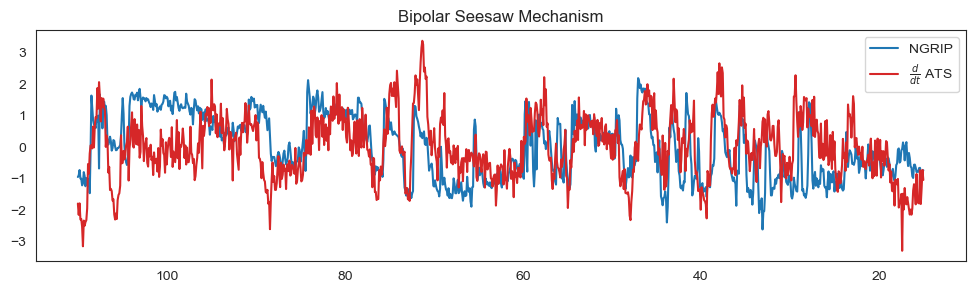

In [67]:
def norm(x):
    return (x - x.mean())/x.std()

plt.figure(figsize=(12, 3))
plt.plot(data_processed.GIS.transform(norm), label="NGRIP")
plt.plot(data_processed.dATS.transform(norm), label=r"$\frac{d}{dt}$ ATS", c="C3")
plt.gca().invert_xaxis()
plt.title("Bipolar Seesaw Mechanism")
plt.legend()
plt.show()

In [72]:
import seaborn as sns
from ipywidgets import interact

@interact(x=data_processed.columns, y=data_processed.columns, lag=(0, 30, 1), event=np.append(np.unique(mask), "All").tolist())
def scatterplot(x="GIS", y="AMOC", event="All", lag=0):
    df = data_processed.copy()
    if event != "All":
        df[mask != event] = np.nan
    sns.jointplot(x=df[x], y=df[y].shift(lag), hue=mask, alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)

interactive(children=(Dropdown(description='x', options=('GIS', 'AMOC', 'ATS', 'dATS'), value='GIS'), Dropdown…

## Causal Inference

In [17]:
def run(df=data_processed, event=None, mask=mask, test=robust_parcorr.RobustParCorr, **kwargs):

    # tigramite dataframe
    df   = data_processing.DataFrame(df.to_numpy()) 
    # instantiate test if necessary
    test = test(**utils.screen(test, kwargs)) if isinstance(test, type) else test

    # mask out Heinrich, DOI or DOS events when needed
    if event is not None:
        mask = mask == event
        mask = utils.expand_mask(mask, df.N)
        df.mask = df._check_mask(mask)
        test.set_mask_type("xy")

    # run pcmciplus
    if "bootstrap_samples" in kwargs:
        return pcmci.PCMCI(df, test).run_bootstrap_of("run_pcmciplus", method_args=utils.screen(pcmci.PCMCI.run_pcmciplus, kwargs), **utils.screen(pcmci.PCMCI.run_bootstrap_of, kwargs))
    else:
        return pcmci.PCMCI(df, test).run_pcmciplus(**utils.screen(pcmci.PCMCI.run_pcmci, kwargs))

In [4]:
# seeds 1234

setups = (
    # ParCorr
    *[{
        "test":  parcorr.ParCorr(),
        "event": event,
        "tau_min": 0,
        "tau_max": 10,
        "pc_alpha": 0.05,
        "bootstrap_samples": 50,
        "seed": 1237,
    } for event in [None, "H", "DOI", "DOS"]],
    # # RobustParCorr
    *[{
        "test":  robust_parcorr.RobustParCorr(),
        "event": event,
        "tau_min": 0,
        "tau_max": 10,
        "pc_alpha": 0.05,
        "bootstrap_samples": 50,
        "seed": 1237,
    } for event in [None, "H", "DOI", "DOS"]],
    # CMIknn
    *[{
        "test": cmiknn.CMIknn(significance="fixed_thres"),
        "event": event,
        "tau_max": 5,
        "pc_alpha": [0.001, 0.005, 0.01, 0.05, 0.1]
    } for event in [None, "H", "DOI", "DOS"]],
)

In [23]:
import warnings
warnings.filterwarnings("ignore")

data = data_processed[["GIS", "AMOC", "dATS"]]

res = []
for setup in setups:
    print(setup)
    res.append(run(data, **setup))
res = np.array(res)

import pickle
with open(f"../data/davtian_causal_graphs_{setups[0]['seed']}.pkl", "wb") as file:
    pickle.dump(res, file)

{'test': <tigramite.independence_tests.parcorr.ParCorr object at 0x16ab08550>, 'event': None, 'tau_min': 0, 'tau_max': 10, 'pc_alpha': 0.05, 'bootstrap_samples': 50, 'seed': 1237}
{'test': <tigramite.independence_tests.parcorr.ParCorr object at 0x2884a8eb0>, 'event': 'H', 'tau_min': 0, 'tau_max': 10, 'pc_alpha': 0.05, 'bootstrap_samples': 50, 'seed': 1237}
{'test': <tigramite.independence_tests.parcorr.ParCorr object at 0x28c16b8e0>, 'event': 'DOI', 'tau_min': 0, 'tau_max': 10, 'pc_alpha': 0.05, 'bootstrap_samples': 50, 'seed': 1237}
{'test': <tigramite.independence_tests.parcorr.ParCorr object at 0x28c170ee0>, 'event': 'DOS', 'tau_min': 0, 'tau_max': 10, 'pc_alpha': 0.05, 'bootstrap_samples': 50, 'seed': 1237}
{'test': <tigramite.independence_tests.robust_parcorr.RobustParCorr object at 0x28c1702b0>, 'event': None, 'tau_min': 0, 'tau_max': 10, 'pc_alpha': 0.05, 'bootstrap_samples': 50, 'seed': 1237}
{'test': <tigramite.independence_tests.robust_parcorr.RobustParCorr object at 0x28c170

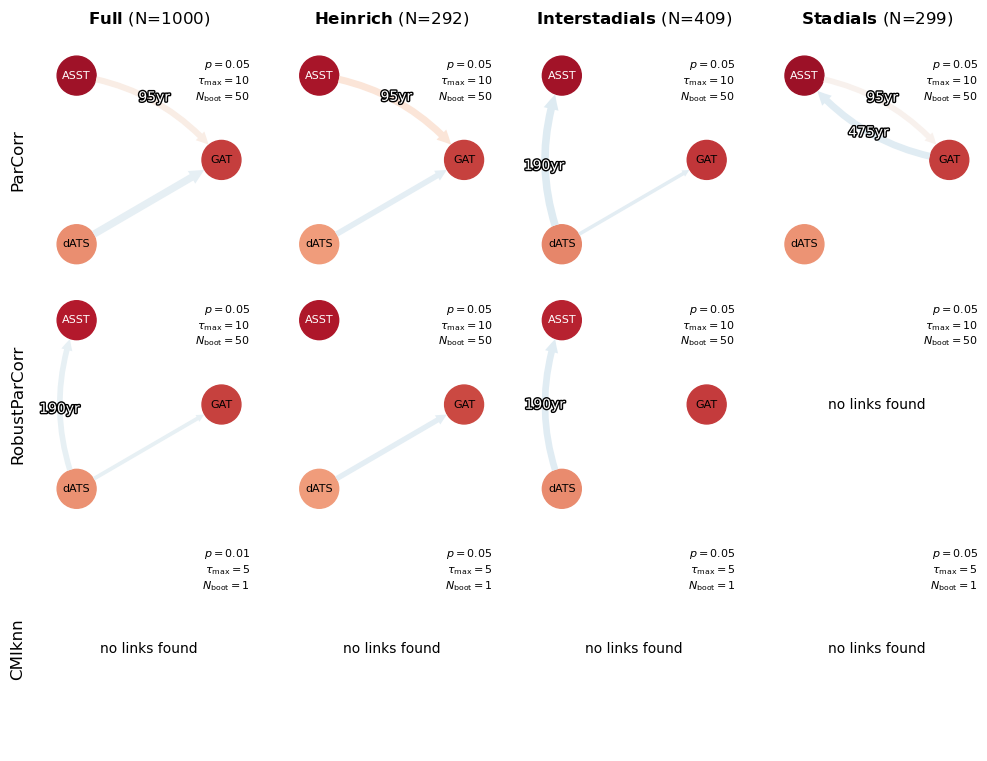

In [11]:
import matplotlib
import pickle

res = None
with open("../data/davtian_causal_graphs_1237.pkl", "rb") as file:
    res = pickle.load(file)

# figure grid for each setup
shape = np.reshape(res, (-1, 4)).shape
fig, axs = plt.subplots(*shape, figsize=(12, 9))
axs = axs.reshape(-1, 4)

# plot graphs in grid
for ax, resi, setup in zip(axs.flatten(), res, setups):

    # lag array in real time units
    form = matplotlib.ticker.EngFormatter(unit="yr", places=0)
    lags = -np.arange(0, setup["tau_max"] + 1)*data_processed.index.diff()[1]*1000
    lags = [form(lag) for lag in lags]

    # meta information
    test  = type(setup["test"]).__name__
    pval  = setup["pc_alpha"] if "optimal_alpha" not in resi else resi["optimal_alpha"]
    tmax  = setup["tau_max"]
    Nboot = setup["bootstrap_samples"] if "bootstrap_samples" in setup else 1
    meta  = f"$p=${pval}, " + r"$\tau_\text{max}=$" + f"{tmax}, " + r"$N_\text{boot}=$" + f"{Nboot}"
    ax.text(1, 1, meta.replace(", ", "\n"), ha="right", va="top", transform=ax.transAxes, fontsize=8)

    # graph, val_matrix, link_width
    if "summary_results" in resi:
        graph = resi["summary_results"]["most_frequent_links"] 
        val_matrix = resi["summary_results"]["val_matrix_mean"]
        link_width = resi["summary_results"]["link_frequency"]
    else:
        graph = resi["graph"]
        val_matrix = resi["val_matrix"]
        link_width = None
   
    # any link found
    any = np.any([graph[idx] != "" for idx in np.ndindex(*graph.shape) if idx[0] != idx[1]])

    if any:
        # plot graph if any relevant link was found
        plotting.plot_graph(graph=graph, 
                            val_matrix=val_matrix, 
                            link_width=link_width, 
                            show_colorbar=False, 
                            var_names=["GAT", "ASST", "dATS"], 
                            fig_ax=(fig, ax),
                            node_label_size=8,
                            node_size=0.4,
                            lag_array=lags)
        
        # correct axis aspect so that nodes are circles
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        aspect = (xlim[1] - xlim[0])/(ylim[1] - ylim[0])
        ax.set_ylim(aspect*ylim[0], aspect*ylim[1])
        
    else:
        # no links found text
        ax.text(0, 0, "no links found", va="center", ha="center", fontsize=10)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.setp(ax.spines.values(), visible=False)
    
    ax.set_facecolor("#ffffff00")

    if ax in axs[:,0]:
        ax.set_ylabel(test + "\n", fontsize=12)


for ax in axs.flatten():
    for child in ax._children:
        if type(child) == matplotlib.text.Text:
            if child.get_text() == "ASST":
                child.set(color="white")
            child.set(text=child.get_text().replace("'", ""))

for i in range(axs.shape[1]):
    N = len(mask) if i == 0 else (mask == ["H", "DOI", "DOS"][i - 1]).sum()
    axs[0,i].set_title(r"$\bf{" + ["Full", "Heinrich", "Interstadials", "Stadials"][i] + r"}$" + f" (N={N})", x=0.5, pad=25, fontsize=12)

plt.savefig(f"../plots/davtian_causal_graphs.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()

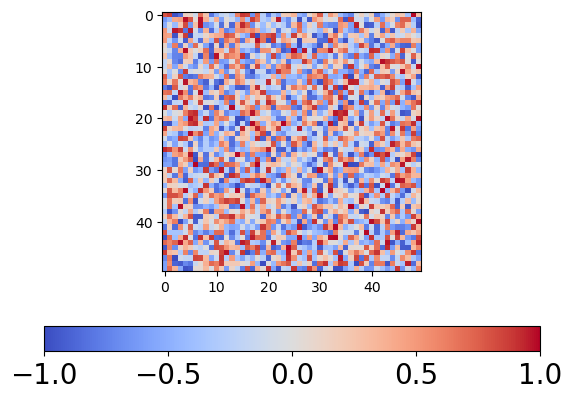

In [46]:
plt.imshow(np.random.uniform(-1, 1, size=(50, 50)), cmap="coolwarm", vmin=-1, vmax=1)
cbar = plt.colorbar(location="bottom", ticks=np.arange(-1, 1.1, 0.5))
cbar.ax.tick_params(labelsize=20)
plt.savefig("../plots/cbar.png", dpi=200, transparent=True)

## Causal Effects

In [6]:
import pickle

res = None
with open("../data/davtian_causal_graphs_1237.pkl", "rb") as file:
    res = pickle.load(file)

In [97]:
import sklearn.preprocessing
from tigramite.models import LinearMediation
from tigramite.causal_effects import CausalEffects
import sklearn

var_names = ["GIS", "AMOC", "dATS"]

effects = []

for i in range(8):
    test  = ["ParCorr", "RobustParCorr", "CMIknn"][i//4]
    event = [None, "H", "DOI", "DOS"][i%4] 

    # tigramite dataframe
    df = data_processing.DataFrame(data_processed[var_names].to_numpy()) 
    if event is not None:
        df.mask = df._check_mask(utils.expand_mask(mask == event, df.N))

    graph = res[i]["summary_results"]["most_frequent_links"]
    val   = res[i]["summary_results"]["val_matrix_mean"]

    dag = pcmci.PCMCI(df, parcorr.ParCorr() if test == "ParCorr" else robust_parcorr.RobustParCorr())
    parents = dag.return_parents_dict(graph, val, include_lagzero_parents=True)

    med = LinearMediation(dataframe=df,
                          mask_type=None if event is None else "xy")
    med.fit_model(all_parents=parents)

    val_mean = np.ma.masked_where(graph != "-->", val).mean(axis=2)
    for i, j in np.ndindex((3, 3)):
        if i != j:
            CE = med.get_ce_max(i, j).round(5)
            effects.append([test, event, var_names[i], var_names[j], val_mean[i, j], CE if CE != 0 else np.nan])

effects = pd.DataFrame(effects, columns=["Test", "Event", "From", "To", "Corr", "CE"])
effects


,Test,Event,From,To,Corr,CE
0,ParCorr,None,GIS,AMOC,--,NaN
1,ParCorr,None,GIS,dATS,--,NaN
2,ParCorr,None,AMOC,GIS,0.074452,0.34314
3,ParCorr,None,AMOC,dATS,--,NaN
4,ParCorr,None,dATS,GIS,-0.092467,-0.08129
5,ParCorr,None,dATS,AMOC,--,NaN
6,ParCorr,H,GIS,AMOC,--,NaN
7,ParCorr,H,GIS,dATS,--,NaN
8,ParCorr,H,AMOC,GIS,0.132143,0.42316
9,ParCorr,H,AMOC,dATS,--,NaN


In [101]:
tce = effects.groupby(["From", "To"])["CE"].mean()
tce/tce.abs().max()

From  To  
AMOC  GIS     1.000000
      dATS         NaN
GIS   AMOC   -0.008232
      dATS         NaN
dATS  AMOC   -0.059866
      GIS    -0.139257
Name: CE, dtype: float64